In [1]:
# ===========================
# IMPORTS & CONFIG
# ===========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib

plt.style.use("ggplot")
sns.set_context("talk")

print("Imports OK ✔️")


Imports OK ✔️


In [2]:
# ===========================
# LOAD DATASET
# ===========================
df = pd.read_csv("../app/data/IoT_Indoor_Air_Quality_Dataset.csv")
print("Dataset chargé ✔️")
display(df.head())
print(df.info())


Dataset chargé ✔️


,Timestamp,Temperature (?C),Humidity (%),CO2 (ppm),PM2.5 (?g/m?),PM10 (?g/m?),TVOC (ppb),CO (ppm),Light Intensity (lux),Motion Detected,Occupancy Count,Ventilation Status
0,18-02-2024 08:00,21.75,63.11,989.74,31.17,89.66,226.83,2.84,646.86,0.0,49.0,Open
1,18-02-2024 08:05,27.51,68.03,924.59,27.32,44.82,116.76,3.12,845.45,1.0,11.0,Open
2,18-02-2024 08:10,25.32,53.51,604.05,73.84,71.08,56.59,3.59,560.03,1.0,29.0,Closed
3,18-02-2024 08:15,23.99,58.52,692.20,62.94,10.90,228.06,2.66,499.84,1.0,28.0,Closed
4,18-02-2024 08:20,19.56,69.34,533.12,26.56,88.06,267.26,1.76,411.36,1.0,16.0,Closed


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97458 entries, 0 to 97457
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Timestamp              97458 non-null  object 
 1   Temperature (?C)       95509 non-null  float64
 2   Humidity (%)           95509 non-null  float64
 3   CO2 (ppm)              95509 non-null  float64
 4   PM2.5 (?g/m?)          95509 non-null  float64
 5   PM10 (?g/m?)           95509 non-null  float64
 6   TVOC (ppb)             95509 non-null  float64
 7   CO (ppm)               95509 non-null  float64
 8   Light Intensity (lux)  95509 non-null  float64
 9   Motion Detected        95509 non-null  float64
 10  Occupancy Count        95509 non-null  float64
 11  Ventilation Status     95509 non-null  object 
dtypes: float64(10), object(2)
memory usage: 8.9+ MB
None


In [3]:
# ===========================
# CLEANING & PREPROCESSING
# ===========================
# Conversion Timestamp
df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors="coerce", dayfirst=True)
df = df.dropna(subset=["Timestamp"])
print("✔️ Timestamp nettoyé")

# Suppression des valeurs aberrantes (IQR)
numeric_cols = ["Temperature (?C)", "Humidity (%)", "CO2 (ppm)",
                "PM2.5 (?g/m?)", "PM10 (?g/m?)", "TVOC (ppb)", "Occupancy Count"]

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    df = df[(df[col] >= lower) & (df[col] <= upper)]

print("✔️ Valeurs aberrantes supprimées")

✔️ Timestamp nettoyé
✔️ Valeurs aberrantes supprimées


In [4]:
# ===========================
# AQI INTERIEUR PERSONNALISE
# ===========================
def compute_indoor_aqi(row):
    score = 0
    # Pollution (OMS)
    score += row["PM2.5 (?g/m?)"] / 35
    score += row["PM10 (?g/m?)"] / 50
    score += row["CO2 (ppm)"] / 1000
    score += row["TVOC (ppb)"] / 220
    # Confort thermique
    score += max(0, abs(row["Temperature (?C)"] - 22)/4)
    score += max(0, abs(row["Humidity (%)"] - 50)/10)
    # Présence
    score += row["Occupancy Count"]/20
    return score

df["AQI_Indoor"] = df.apply(compute_indoor_aqi, axis=1)

# Création de labels basés sur percentiles
percentiles = np.percentile(df["AQI_Indoor"], [33, 66])
df["AQI_Label"] = pd.cut(df["AQI_Indoor"],
                          bins=[-np.inf, percentiles[0], percentiles[1], np.inf],
                          labels=["Good", "Moderate", "Poor"])
print(df["AQI_Label"].value_counts())


AQI_Label
Poor        28764
Good        27918
Moderate    27918
Name: count, dtype: int64


In [5]:
# ===========================
# FEATURE ENGINEERING
# ===========================

# Renommage uniquement des colonnes utilisées
df = df.rename(columns={
    "Temperature (?C)": "temperature",
    "Humidity (%)": "humidity",
    "CO2 (ppm)": "co2",
    "PM2.5 (?g/m?)": "pm25",
    "PM10 (?g/m?)": "pm10",
    "TVOC (ppb)": "tvoc",
    "Occupancy Count": "occupancy"
})

features = ["temperature", "humidity", "co2", "pm25", "pm10", "tvoc", "occupancy"]

target = "AQI_Label"

X = df[features]
y = df[target]

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (84600, 7)
y shape: (84600,)


<Figure size 1600x600 with 0 Axes>

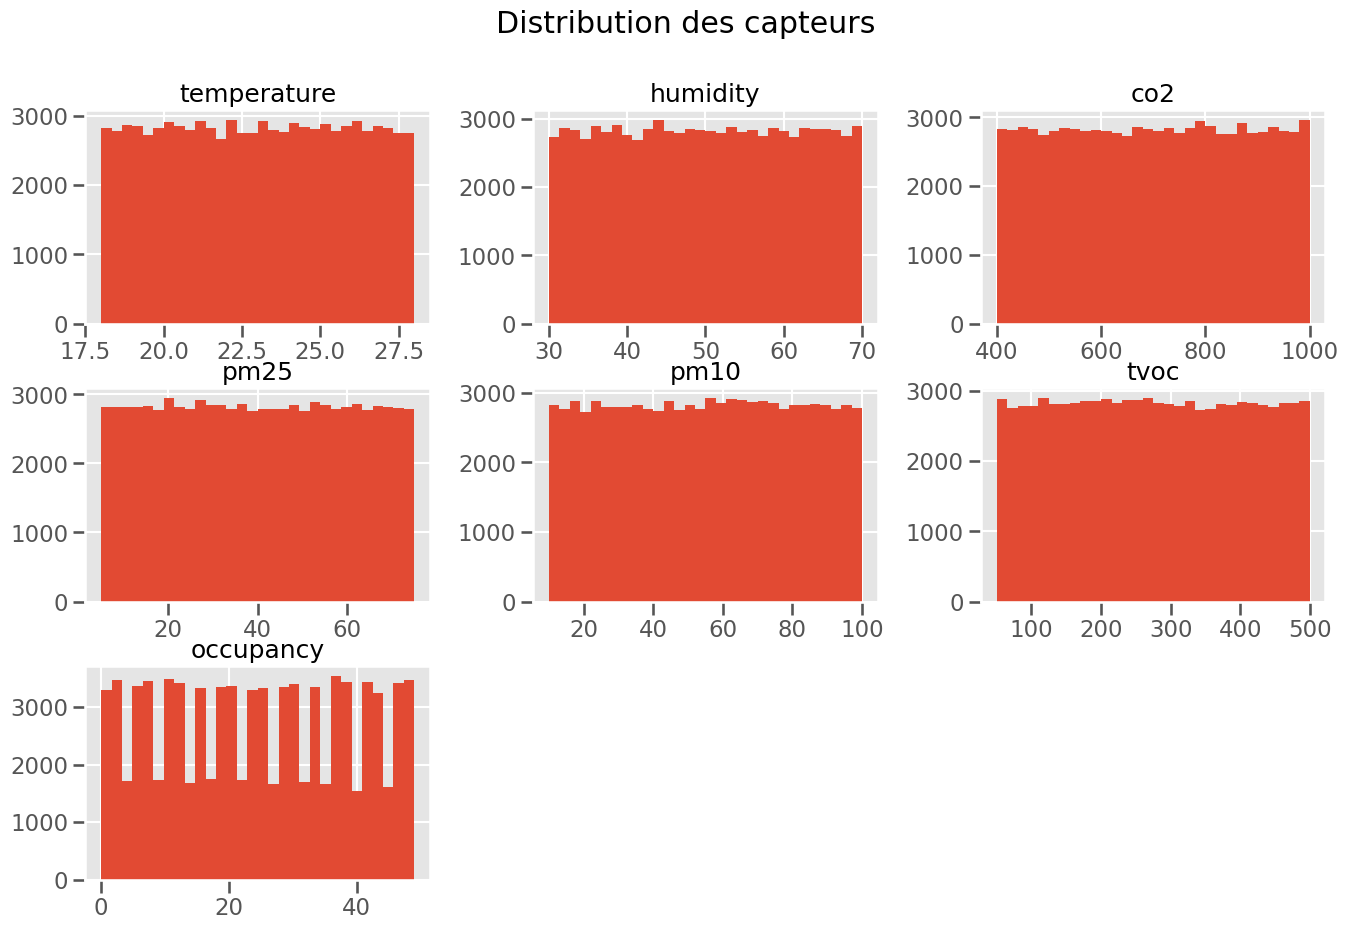

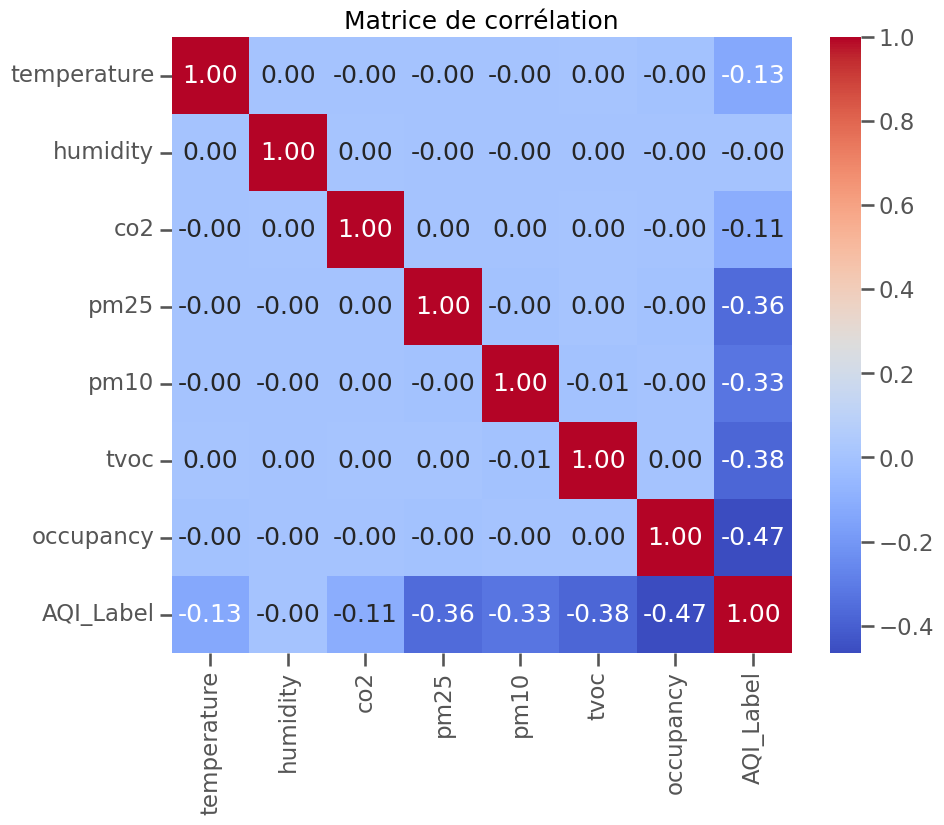

In [6]:
# ===========================
# EXPLORATORY DATA ANALYSIS
# ===========================
plt.figure(figsize=(16,6))
df[features].hist(bins=30, figsize=(16,10))
plt.suptitle("Distribution des capteurs")
plt.show()

corr = df[features + [target]].apply(lambda x: pd.factorize(x)[0] if x.name==target else x).corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matrice de corrélation")
plt.show()


In [7]:
# ===========================
# TRAIN / TEST SPLIT
# ===========================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train size:", X_train.shape, "Test size:", X_test.shape)
print("Répartition des classes:", y_train.value_counts(normalize=True))


Train size: (67680, 7) Test size: (16920, 7)
Répartition des classes: AQI_Label
Poor        0.339997
Moderate    0.330009
Good        0.329994
Name: proportion, dtype: float64


In [8]:
# ===========================
# MODEL TRAINING
# ===========================
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    class_weight="balanced",
    random_state=42
)
model.fit(X_train, y_train)
print("✔️ Modèle entraîné")


✔️ Modèle entraîné


              precision    recall  f1-score   support

        Good       0.90      0.85      0.87      5584
    Moderate       0.74      0.81      0.77      5583
        Poor       0.91      0.87      0.89      5753

    accuracy                           0.84     16920
   macro avg       0.85      0.84      0.85     16920
weighted avg       0.85      0.84      0.85     16920



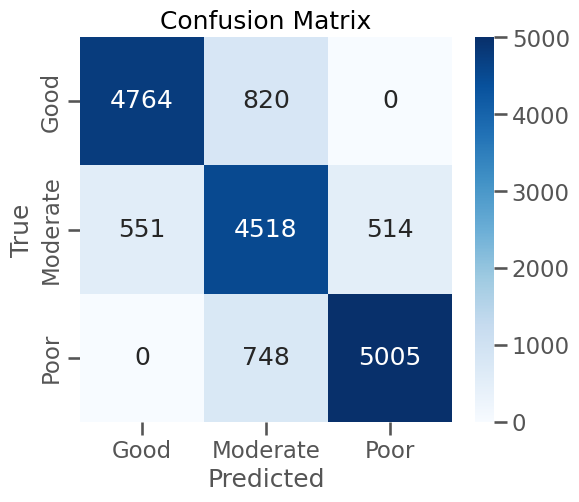

In [9]:
# ===========================
# EVALUATION
# ===========================
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=["Good","Moderate","Poor"])
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Good","Moderate","Poor"],
            yticklabels=["Good","Moderate","Poor"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


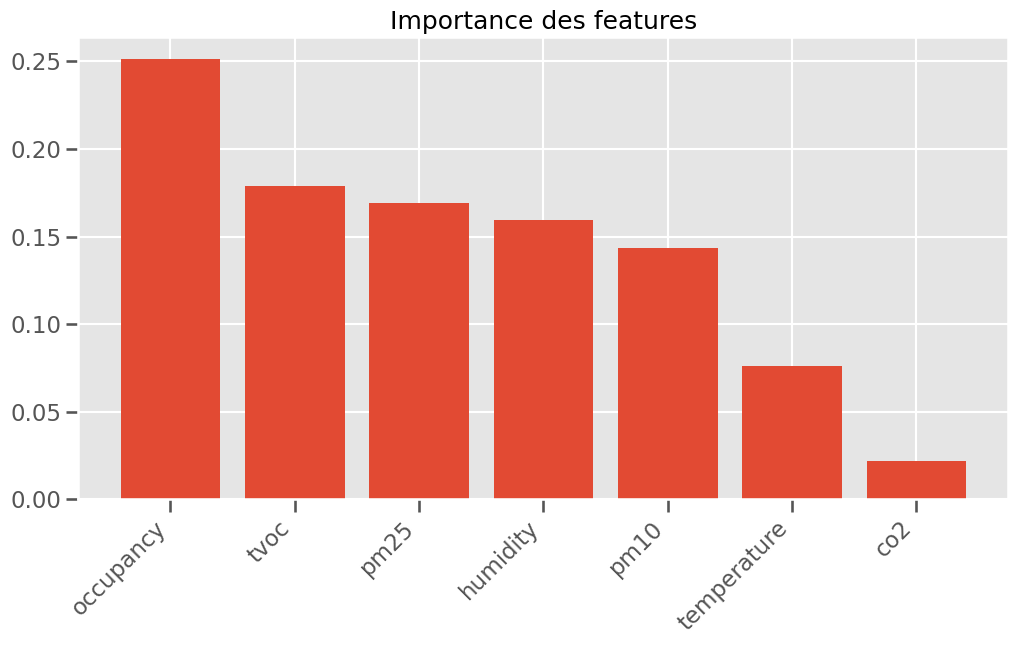

In [10]:
# ===========================
# FEATURE IMPORTANCE
# ===========================
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12,6))
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), np.array(features)[indices], rotation=45, ha="right")
plt.title("Importance des features")
plt.show()


In [11]:
# ===========================
# SAVE MODEL
# ===========================
joblib.dump(model, "../app/data/indoor_aqi_model.pkl", compress=3)
print("✔️ Modèle sauvegardé sous 'indoor_aqi_model.pkl'")


✔️ Modèle sauvegardé sous 'indoor_aqi_model.pkl'


In [12]:
# ===========================
# TESTS DU MODELE (EXEMPLES)
# ===========================

# Exemples de tests avec les colonnes renommées pour le ML
sample_tests = [
    {"temperature": 28.0, "humidity": 70.0, "co2": 1800, "pm25": 80.0, "pm10": 120.0, "tvoc": 400, "occupancy": 50},
    {"temperature": 30.0, "humidity": 50.0, "co2": 500, "pm25": 10.0, "pm10": 15.0, "tvoc": 50, "occupancy": 5},
    # Attendu : Moderate (la température dépasse 26°C)
    {"temperature": 22.0, "humidity": 45.0, "co2": 400, "pm25": 8.0, "pm10": 12.0, "tvoc": 30, "occupancy": 0},
    # Attendu : Good
    {"temperature": 24.0, "humidity": 55.0, "co2": 1200, "pm25": 40.0, "pm10": 60.0, "tvoc": 250, "occupancy": 30}
    # Attendu : Poor ou Moderate selon la combinaison exacte des seuils
]

# Chargement du modèle
loaded_model = joblib.load("../app/data/indoor_aqi_model.pkl")

# Boucle de prédiction
for ex in sample_tests:
    df_ex = pd.DataFrame([ex])
    pred = loaded_model.predict(df_ex)[0]
    print(f"Exemple:\n{df_ex}")
    print(f"➡️ Prédiction AQI_Label: {pred}\n")


Exemple:
   temperature  humidity   co2  pm25   pm10  tvoc  occupancy
0         28.0      70.0  1800  80.0  120.0   400         50
➡️ Prédiction AQI_Label: Poor

Exemple:
   temperature  humidity  co2  pm25  pm10  tvoc  occupancy
0         30.0      50.0  500  10.0  15.0    50          5
➡️ Prédiction AQI_Label: Good

Exemple:
   temperature  humidity  co2  pm25  pm10  tvoc  occupancy
0         22.0      45.0  400   8.0  12.0    30          0
➡️ Prédiction AQI_Label: Good

Exemple:
   temperature  humidity   co2  pm25  pm10  tvoc  occupancy
0         24.0      55.0  1200  40.0  60.0   250         30
➡️ Prédiction AQI_Label: Moderate

